In [7]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('../../data/IAG.xlsx')

# Create the cross-tabulation
result = pd.crosstab(df['iag_product_type_auto'], 
                     df['Likely to recommend'],
                     margins=True)

# Ensure column order matches the expected categories
result = result.reindex(columns=['Detract', 'Passive', 'Promote', 'Super Detract', 'All'])

print("\nProduct Type Distribution by NPS Category:")
print(result)

# Calculate percentages
percentages = pd.crosstab(df['iag_product_type_auto'], 
                         df['Likely to recommend'],
                         normalize='index') * 100

# Ensure same column order in percentages
percentages = percentages.reindex(columns=['Detract', 'Passive', 'Promote', 'Super Detract'])

print("\nPercentages by Product Type:")
print(percentages.round(2))


Product Type Distribution by NPS Category:
Likely to recommend    Detract  Passive  Promote  Super Detract   All
iag_product_type_auto                                                
Content                      6       45      148             11   210
EasyRider                    0        1        0              0     1
Home                         9       23       38             10    80
Home Pack                    9       44       96             16   165
Homeowners Line            190      639     1880            227  2936
Jetsetter                    0        0        1              0     1
Landlord                     0        1        2              3     6
Private Motor Line         252      999     3388            304  4943
Vehicle                     43      200      544             61   848
Wheels                       3       17       54              0    74
All                        512     1969     6151            632  9264

Percentages by Product Type:
Likely to recomm

In [8]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# Read the Excel file
df = pd.read_excel('../../data/IAG.xlsx')

# Create initial contingency table
contingency_table = pd.crosstab(df['iag_product_type_auto'], df['Likely to recommend'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Check which groups violate chi-square assumptions
# Chi-square test assumes expected frequencies > 5 in at least 80% of cells
expected_df = pd.DataFrame(
    expected, 
    index=contingency_table.index, 
    columns=contingency_table.columns
)

# Calculate percentage of cells with expected frequency < 5 for each product type
violation_check = (expected_df < 5).sum(axis=1) / expected_df.shape[1] * 100

print("Percentage of cells with expected frequency < 5 for each product type:")
print(violation_check)

print("\nGroups to exclude based on chi-square assumptions:")
print("(Groups where more than 20% of cells have expected frequency < 5)")
exclude_groups = violation_check[violation_check > 20].index
print(exclude_groups.tolist())

# Filter the dataframe
df_filtered = df[~df['iag_product_type_auto'].isin(exclude_groups)]

# Show results for filtered data
result = pd.crosstab(df_filtered['iag_product_type_auto'], 
                     df_filtered['Likely to recommend'],
                     margins=True)

print("\nProduct Type Distribution after chi-square based filtering:")
print(result)

# Chi-square test on filtered data
filtered_contingency = pd.crosstab(df_filtered['iag_product_type_auto'], 
                                  df_filtered['Likely to recommend'])
chi2_filtered, p_value_filtered, dof_filtered, expected_filtered = chi2_contingency(filtered_contingency)

print("\nChi-square test results after filtering:")
print(f"Chi-square statistic: {chi2_filtered:.2f}")
print(f"p-value: {p_value_filtered:.10f}")
print(f"Degrees of freedom: {dof_filtered}")

Percentage of cells with expected frequency < 5 for each product type:
iag_product_type_auto
Content                 0.0
EasyRider             100.0
Home                   25.0
Home Pack               0.0
Homeowners Line         0.0
Jetsetter             100.0
Landlord              100.0
Private Motor Line      0.0
Vehicle                 0.0
Wheels                 25.0
dtype: float64

Groups to exclude based on chi-square assumptions:
(Groups where more than 20% of cells have expected frequency < 5)
['EasyRider', 'Home', 'Jetsetter', 'Landlord', 'Wheels']

Product Type Distribution after chi-square based filtering:
Likely to recommend    Detract  Passive  Promote  Super Detract   All
iag_product_type_auto                                                
Content                      6       45      148             11   210
Home Pack                    9       44       96             16   165
Homeowners Line            190      639     1880            227  2936
Private Motor Line        

# Chi-Square Analysis for Product Type and NPS Categories

## Technical Approach
**Analysis Method:** Chi-Square Test of Independence
- Tests relationship between product types and NPS categories
- Validates statistical significance of observed patterns
- Filters out product groups with insufficient data

## Data Filtering Process
1. **Chi-Square Assumptions Check**
  - Requirement: No more than 20% of cells should have expected frequency < 5
  - Groups excluded due to violation:
    - Complete violation (100%): EasyRider, Jetsetter, Landlord
    - Partial violation (25%): Home, Wheels

2. **Retained Product Groups**
  - Content (210 cases)
  - Home Pack (165 cases)
  - Homeowners Line (2,936 cases)
  - Private Motor Line (4,943 cases)
  - Vehicle (848 cases)
  - Total valid cases: 9,102

## Statistical Results
- Chi-square statistic: 35.29
- Degrees of freedom: 12
- p-value: 0.00042 (< 0.05)

## Key Findings
1. **Statistical Significance**
  - Strong evidence of relationship between product type and NPS categories
  - Less than 0.05% chance this relationship is due to random chance

2. **Data Quality**
  - 5 out of 10 product groups had sufficient data for analysis
  - Retained groups represent 98% of total customer feedback
  - Analysis maintains statistical validity while excluding unreliable data

## Business Implications
1. Focus analysis on five major product lines with reliable data
2. Results can be used for evidence-based decision making
3. Smaller product groups need different evaluation methods

*Note: This chi-square analysis provided the foundation for subsequent detailed analyses using standardized residuals and other methods.*

Standardized Residuals (values > 2 or < -2 are significant):
Likely to recommend    Detract  Passive  Promote  Super Detract
iag_product_type_auto                                          
Content                  -1.63     0.08     0.70          -0.87
Home Pack                -0.02     1.53    -1.32           1.43
Homeowners Line           2.26     0.70    -1.66           1.93
Private Motor Line       -1.19    -1.47     1.73          -1.75
Vehicle                  -0.52     1.53    -0.85           0.44


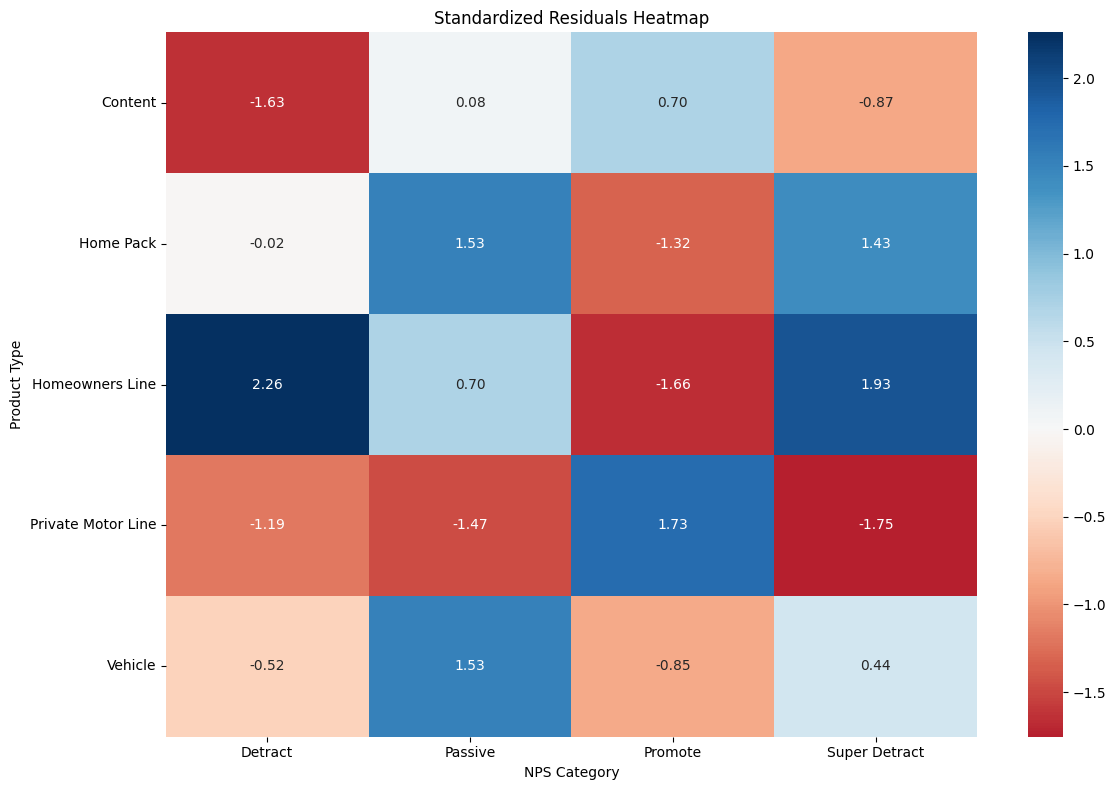


Significant Patterns (|residual| > 2):
Homeowners Line has significantly more Detract responses than expected (residual = 2.26)


In [9]:
# standardized residuals

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file
df = pd.read_excel('../../data/IAG.xlsx')

# Filter out statistically insignificant groups (as per our previous chi-square analysis)
exclude_groups = ['EasyRider', 'Home', 'Jetsetter', 'Landlord', 'Wheels']
df_filtered = df[~df['iag_product_type_auto'].isin(exclude_groups)]

# Create contingency table
contingency_table = pd.crosstab(df_filtered['iag_product_type_auto'], 
                               df_filtered['Likely to recommend'])

# Calculate standardized residuals
chi2_stats = stats.chi2_contingency(contingency_table)
expected = chi2_stats[3]
observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)

# Convert to DataFrame for better visualization
residuals_df = pd.DataFrame(
    standardized_residuals,
    index=contingency_table.index,
    columns=contingency_table.columns
)

print("Standardized Residuals (values > 2 or < -2 are significant):")
print(residuals_df.round(2))

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(residuals_df, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('Standardized Residuals Heatmap')
plt.xlabel('NPS Category')
plt.ylabel('Product Type')
plt.tight_layout()
plt.show()

# Interpret significant residuals
print("\nSignificant Patterns (|residual| > 2):")
for product in residuals_df.index:
    for category in residuals_df.columns:
        residual = residuals_df.loc[product, category]
        if abs(residual) > 2:
            direction = "more" if residual > 0 else "fewer"
            print(f"{product} has significantly {direction} {category} responses than expected (residual = {residual:.2f})")

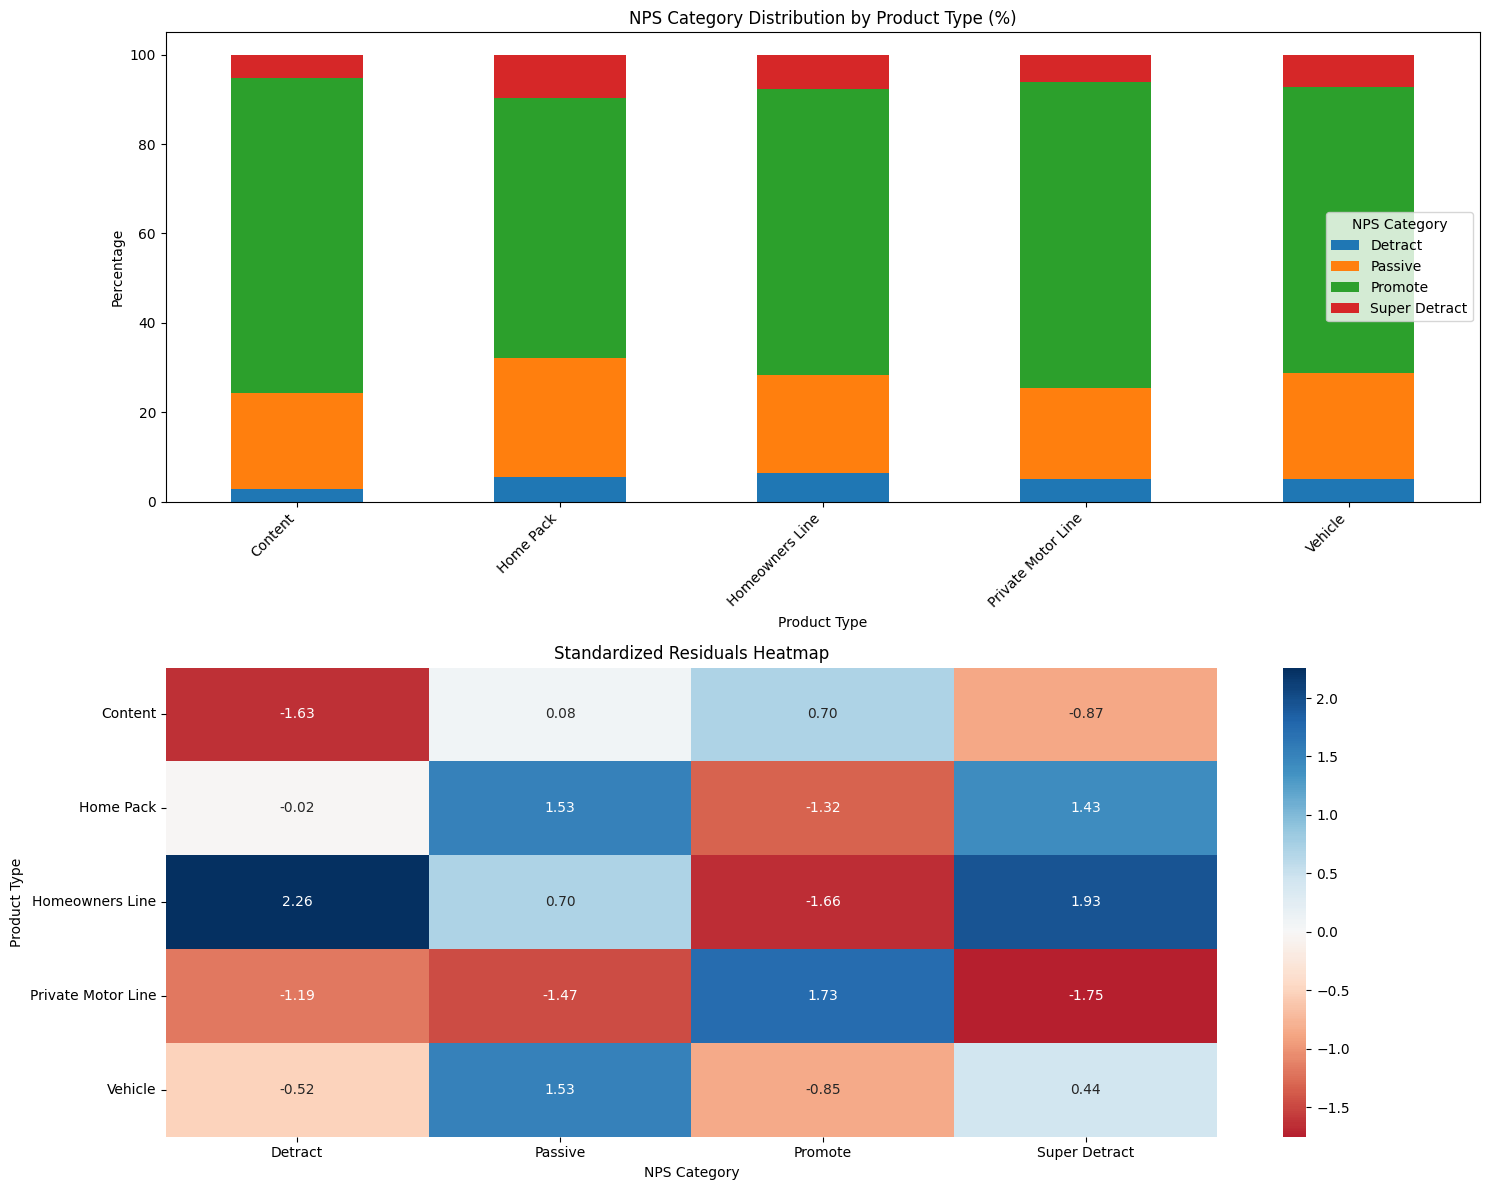

In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file
df = pd.read_excel('../../data/IAG.xlsx')

# Filter out statistically insignificant groups
exclude_groups = ['EasyRider', 'Home', 'Jetsetter', 'Landlord', 'Wheels']
df_filtered = df[~df['iag_product_type_auto'].isin(exclude_groups)]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 1. Stacked Bar Chart
props = pd.crosstab(df_filtered['iag_product_type_auto'], 
                    df_filtered['Likely to recommend'], 
                    normalize='index') * 100
props.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('NPS Category Distribution by Product Type (%)')
ax1.set_xlabel('Product Type')
ax1.set_ylabel('Percentage')
ax1.legend(title='NPS Category')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. Heatmap
contingency_table = pd.crosstab(df_filtered['iag_product_type_auto'], 
                               df_filtered['Likely to recommend'])
chi2_stats = stats.chi2_contingency(contingency_table)
expected = chi2_stats[3]
observed = contingency_table.values
standardized_residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(
    standardized_residuals,
    index=contingency_table.index,
    columns=contingency_table.columns
)

sns.heatmap(residuals_df, annot=True, cmap='RdBu', center=0, fmt='.2f', ax=ax2)
ax2.set_title('Standardized Residuals Heatmap')
ax2.set_xlabel('NPS Category')
ax2.set_ylabel('Product Type')

plt.tight_layout()
plt.show()

# Customer Satisfaction Analysis Across Product Types - Standardized Residuals Analysis

## Technical Approach
**Analysis Method:** Standardized Residual Analysis
- Measures the difference between observed and expected frequencies in terms of standard deviations
- Identifies specific combinations that deviate significantly from expected values
- Significance threshold: Values > |2| indicate statistically significant deviations

## Statistical Validation
- Chi-square test p-value = 0.00042 < 0.05
- Confirms significant relationship between product types and NPS categories
- Justifies deeper analysis of specific relationships

## Analysis Results by Product Type

### 1. Homeowners Line (Significant Deviations)
- **Critical Finding**: Only category with statistically significant deviation
- Detract responses: +2.26 standard deviations (exceeds significance threshold)
- Super Detract: +1.93 standard deviations
- Promote: -1.66 standard deviations
- Pattern indicates systematic customer satisfaction issues

### 2. Private Motor Line (Notable Patterns)
- Promote: +1.73 standard deviations
- Negative deviations in other categories:
  - Passive: -1.47
  - Detract: -1.19
  - Super Detract: -1.75
- Shows consistent positive trend though not crossing significance threshold

### 3. Vehicle and Home Pack (Moderate Deviations)
- Both show +1.53 standard deviations in Passive category
- Other deviations are relatively minor
- Indicates neutral customer sentiment trending stronger than expected

### 4. Content (Minimal Deviations)
- All residuals < |2|
- Closest to expected distribution
- Most balanced performance across categories

## Visualization Components

### 1. Percentage Distribution (Stacked Bar Chart)
- Shows raw proportions of NPS categories
- Provides baseline for comparing actual distributions
- Helps identify dominant response categories

### 2. Standardized Residuals (Heatmap)
- Blue: More occurrences than expected
- Red: Fewer occurrences than expected
- Color intensity: Magnitude of deviation
- Numerical values: Exact standard deviations from expected

## Business Implications

1. **Risk Management (Homeowners Line)**
   - Only product showing statistically significant deviation
   - Higher detractor rate requires immediate intervention
   - Potential systemic issues needing address

2. **Success Model (Private Motor Line)**
   - Consistent positive trends
   - Could serve as internal benchmark
   - Practices potentially transferable to other products

3. **Conversion Opportunity (Vehicle & Home Pack)**
   - Strong neutral customer base
   - Opportunity for targeted promotion strategies
   - Focus on passive-to-promoter conversion

4. **Stability Reference (Content)**
   - Most balanced performance
   - Could serve as baseline for measuring interventions
   - May benefit from more distinctive positioning

## Next Steps
1. Compare these findings with Cramer's V analysis
2. Look for consistency in patterns across different analytical methods
3. Develop weighted recommendations based on multiple analytical perspectives

*Note: This analysis uses standardized residuals as the primary analytical tool. Subsequent analyses using different methods (e.g., Cramer's V)

Overall Cramer's V: 0.0359

Effect Size Interpretation:
< 0.10: Negligible effect
0.10 - 0.20: Weak effect
0.20 - 0.40: Moderate effect
0.40 - 0.60: Relatively strong effect
0.60 - 0.80: Strong effect
0.80 - 1.00: Very strong effect

Effect Sizes by Product and NPS Category:
NPS Category        Detract  Passive  Promote  Super Detract
Product                                                     
Content              0.0162   0.0001   0.0121         0.0081
Home Pack            0.0000   0.0173   0.0232         0.0140
Homeowners Line      0.0291   0.0097   0.0363         0.0250
Private Motor Line   0.0184   0.0254   0.0461         0.0277
Vehicle              0.0051   0.0185   0.0158         0.0042


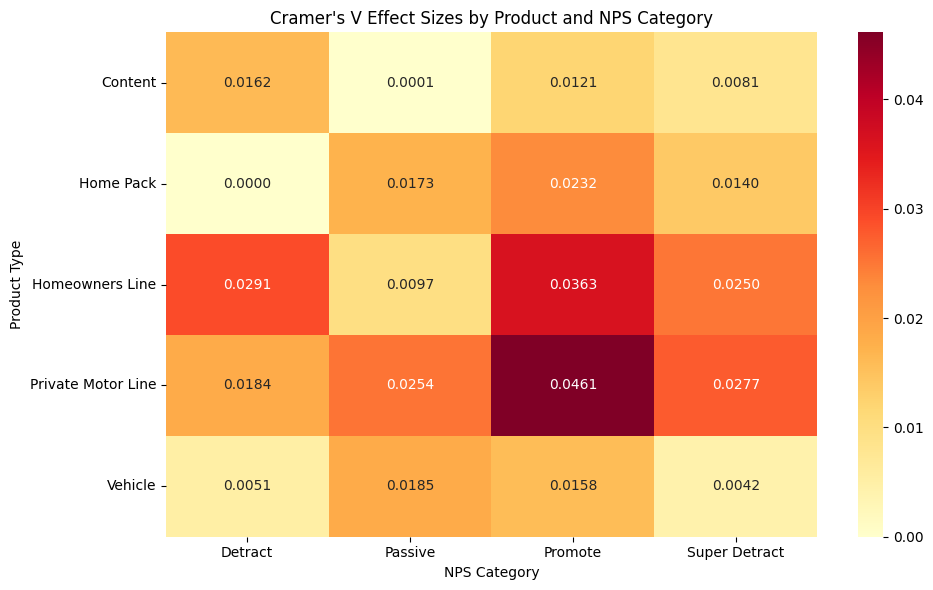

In [1]:
# effect size analysi - cramer's V    

import pandas as pd
import numpy as np
from scipy import stats

# Read the Excel file
df = pd.read_excel('../../data/IAG.xlsx')

# Filter out statistically insignificant groups as per previous chi-square analysis
exclude_groups = ['EasyRider', 'Home', 'Jetsetter', 'Landlord', 'Wheels']
df_filtered = df[~df['iag_product_type_auto'].isin(exclude_groups)]

# Create contingency table
contingency_table = pd.crosstab(df_filtered['iag_product_type_auto'], 
                               df_filtered['Likely to recommend'])

# Calculate Cramer's V
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

cramer_v = cramers_v(contingency_table)

# Calculate effect size for each product type separately
product_effects = {}
for product in contingency_table.index:
    # Create 2x2 contingency tables for each product vs others
    product_data = df_filtered['iag_product_type_auto'] == product
    for nps_category in contingency_table.columns:
        nps_data = df_filtered['Likely to recommend'] == nps_category
        table_2x2 = pd.crosstab(product_data, nps_data)
        v = cramers_v(table_2x2)
        product_effects[(product, nps_category)] = v

# Convert to DataFrame for better visualization
effect_size_df = pd.DataFrame([(k[0], k[1], v) for k, v in product_effects.items()],
                             columns=['Product', 'NPS Category', 'Effect Size'])
effect_size_pivot = effect_size_df.pivot(index='Product', 
                                       columns='NPS Category', 
                                       values='Effect Size')

print("Overall Cramer's V:", round(cramer_v, 4))
print("\nEffect Size Interpretation:")
print("< 0.10: Negligible effect")
print("0.10 - 0.20: Weak effect")
print("0.20 - 0.40: Moderate effect")
print("0.40 - 0.60: Relatively strong effect")
print("0.60 - 0.80: Strong effect")
print("0.80 - 1.00: Very strong effect")

print("\nEffect Sizes by Product and NPS Category:")
print(effect_size_pivot.round(4))

# Visualize the effect sizes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(effect_size_pivot, annot=True, cmap='YlOrRd', fmt='.4f')
plt.title("Cramer's V Effect Sizes by Product and NPS Category")
plt.ylabel('Product Type')
plt.xlabel('NPS Category')
plt.tight_layout()
plt.show()

# Effect Size Analysis using Cramer's V

## Technical Approach
**Analysis Method:** Cramer's V Effect Size Analysis
- Measures the strength of association between categorical variables
- Values range from 0 (no association) to 1 (perfect association)
- Calculated for overall relationship and individual category combinations

## Overall Results
- Overall Cramer's V: 0.0359
- Interpretation: Negligible effect (< 0.10)
- Indicates weak overall association between product types and NPS categories

## Detailed Effect Size Analysis

### Strongest Associations
1. **Private Motor Line - Promote**: 0.0461
  - Highest individual effect size
  - Still classified as negligible effect
  - Consistent with previous residual analysis showing positive promotion trend

2. **Homeowners Line - Promote**: 0.0363
  - Second highest effect size
  - Negative association (from residual analysis)
  - Validates previous findings about customer satisfaction issues

### Product-wise Patterns
1. **Private Motor Line**
  - Most consistent effect sizes across categories
  - Strongest association with Promote (0.0461)
  - Validates previous findings of overall positive performance

2. **Homeowners Line**
  - Second strongest associations overall
  - Notable effects in both Promote (0.0363) and Detract (0.0291)
  - Confirms complex customer satisfaction pattern

3. **Vehicle and Content**
  - Weakest associations overall
  - Most values below 0.02
  - Suggests more random distribution of responses

## Key Insights
1. All effect sizes fall in the 'negligible' range (< 0.10)
2. Product type has limited predictive power for NPS category
3. Relationships identified in residual analysis, while statistically significant, are relatively weak

## Business Implications
1. Need for multifaceted approach to customer satisfaction
2. Product type alone not strong determinant of customer satisfaction
3. Other factors likely play more significant roles in NPS scores

*Note: While previous chi-square analysis showed significant relationships, Cramer's V reveals these relationships are weak in practical terms.*

# Comparative Analysis: Statistical Significance vs Effect Size
## Integration of Chi-Square, Standardized Residuals, and Cramer's V Results

### Overview of Analytical Methods
1. **Chi-Square & Standardized Residuals Analysis**
  - Purpose: Tests existence of relationship between product types and NPS
  - Key metric: p-value = 0.00042 (< 0.05)
  - Standardized residuals threshold: |2|

2. **Cramer's V Effect Size Analysis**
  - Purpose: Measures strength of identified relationships
  - Overall effect: 0.0359 (negligible)
  - Individual effects range: 0.0000 to 0.0461

### Synthesis of Findings

#### Statistical Significance (Chi-Square & Residuals)
- **Valid Relationship Confirmed**
 - p-value < 0.05 confirms non-random patterns
 - Homeowners Line shows significant deviation in Detract responses (2.26)
 - Private Motor Line shows consistent positive trends
 
#### Practical Significance (Cramer's V)
- **Weak Overall Association**
 - All effect sizes fall under 0.10 (negligible effect)
 - Strongest effect: Private Motor Line - Promote (0.0461)
 - Product type alone has limited predictive power

### Reconciliation of Results
The analyses are complementary, not contradictory:
1. **Pattern Existence** (Chi-Square): ✓ YES
  - Statistically significant relationships exist
  - Patterns are not due to random chance

2. **Pattern Strength** (Cramer's V): ⚠️ WEAK
  - Relationships exist but are not strong
  - Product type is not a dominant factor in NPS scores

### Business Context
1. **Valid but Limited Product Effects**
  - Product-specific patterns are real
  - But their impact on NPS is relatively small

2. **Action Implications**
  - Address identified product issues (especially Homeowners Line)
  - Look beyond product type for major NPS improvements
  - Consider multi-factor analysis for stronger predictors

### Recommendations
1. **Short-term**
  - Address significant product-specific issues identified
  - Focus on Homeowners Line's higher detractor rate

2. **Long-term**
  - Investigate other potential NPS influencers
  - Consider analyzing:
    - Customer demographics
    - Service delivery metrics
    - Price points
    - Claims processing times
    - Customer interaction channels

*Note: This integrated analysis provides a more nuanced understanding of the relationship between product types and NPS categories, highlighting both the statistical validity and practical limitations of product-based effects on customer satisfaction.*